In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------
def build_scriptnet(input_shape=(64, 64, 1), num_classes=83):
    inputs = Input(shape=input_shape, name='input_layer')

    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNet')
    return model

2025-05-31 17:13:23.085500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748711603.294751      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748711603.354284      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ----------------------------
# 2. Data Loading: BanglaLekha-Isolated
# ----------------------------
# Replace this with your full Google Drive path if needed
dataset_path = "/kaggle/input/bangla-lekha-isolated-dataset/BanglaLekha-Isolated/Images/"

input_shape = (64, 64, 1)
batch_size = 64
epochs = 60
num_classes = 84  # Update if using fewer classes

# ImageDataGenerator with augmentation for training and only rescaling for validation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,

    #Augmentation settings for handwritten characters
    rotation_range=5,          # small rotations
    zoom_range=0.05,             # slight zoom in/out
    width_shift_range=0.05,      # horizontal shift
    height_shift_range=0.05,     # vertical shift
    shear_range=0.05,            # slight shear transformation
    fill_mode='nearest'         # fill pixels after transformation
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=42
)

Found 132914 images belonging to 84 classes.
Found 33191 images belonging to 84 classes.


In [3]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1748711989.211843      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748711989.212534      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,805,716 (33.59 MB)

 Trainable params: 8,803,796 (33.58 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [4]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_banglalekha_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1748712023.193130     114 service.cc:148] XLA service 0x7b8324006cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748712023.193911     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748712023.193932     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748712023.754862     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2077 ━━━━━━━━━━━━━━━━━━━━ 6:50:14 12s/step - accuracy: 0.0312 - loss: 5.1829

I0000 00:00:1748712030.155258     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.5148 - loss: 1.9116
Epoch 1: val_accuracy improved from -inf to 0.84839, saving model to scriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 1332s 636ms/step - accuracy: 0.5149 - loss: 1.9114 - val_accuracy: 0.8484 - val_loss: 0.5176 - learning_rate: 0.0010
Epoch 2/60
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7743 - loss: 0.8059
Epoch 2: val_accuracy improved from 0.84839 to 0.91456, saving model to scriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 393s 189ms/step - accuracy: 0.7743 - loss: 0.8059 - val_accuracy: 0.9146 - val_loss: 0.3068 - learning_rate: 0.0010
Epoch 3/60
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8214 - loss: 0.6324
Epoch 3: val_accuracy improved from 0.91456 to 0.92170, saving model to scriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 383s 184ms/step - accuracy: 0.8214 - loss: 0.6324 - val_accuracy: 0.9217 - val_loss: 0.2756 - learning_rate: 0.0

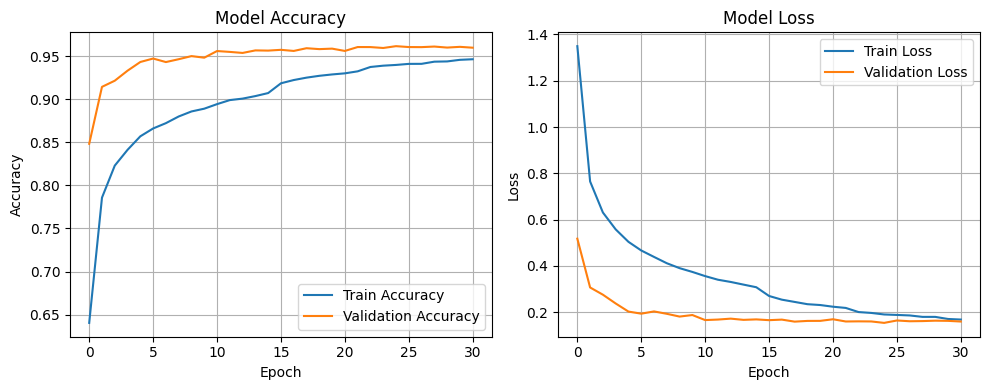

In [5]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

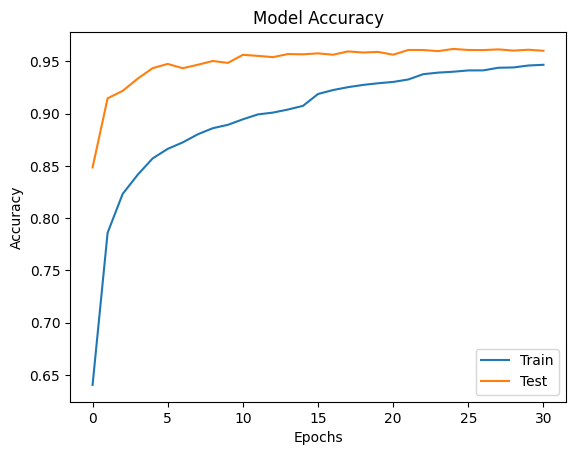

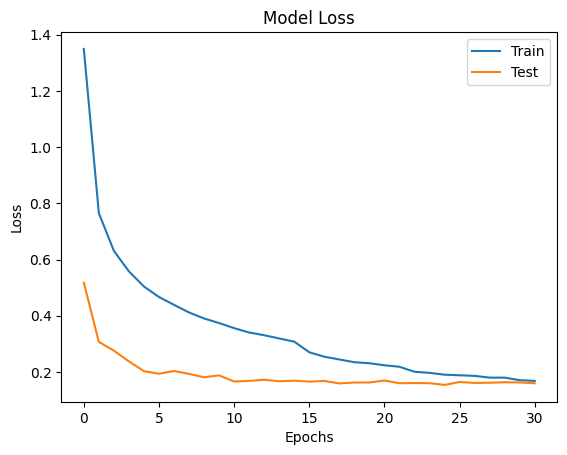

In [6]:
# plot the convergence, in terms of accuracy and loss, of ScriptNet
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

519/519 ━━━━━━━━━━━━━━━━━━━━ 54s 102ms/step


<Figure size 1200x1200 with 0 Axes>

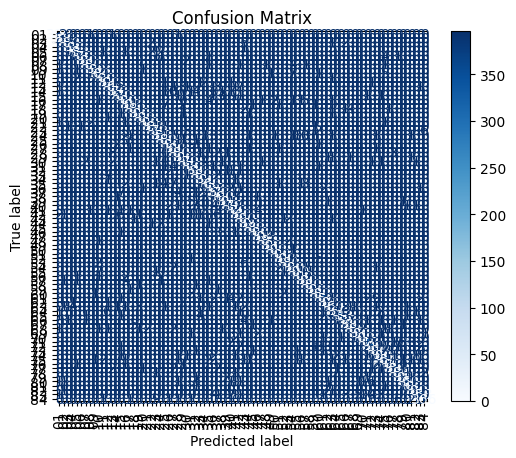

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
plt.figure(figsize=(12, 12))
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

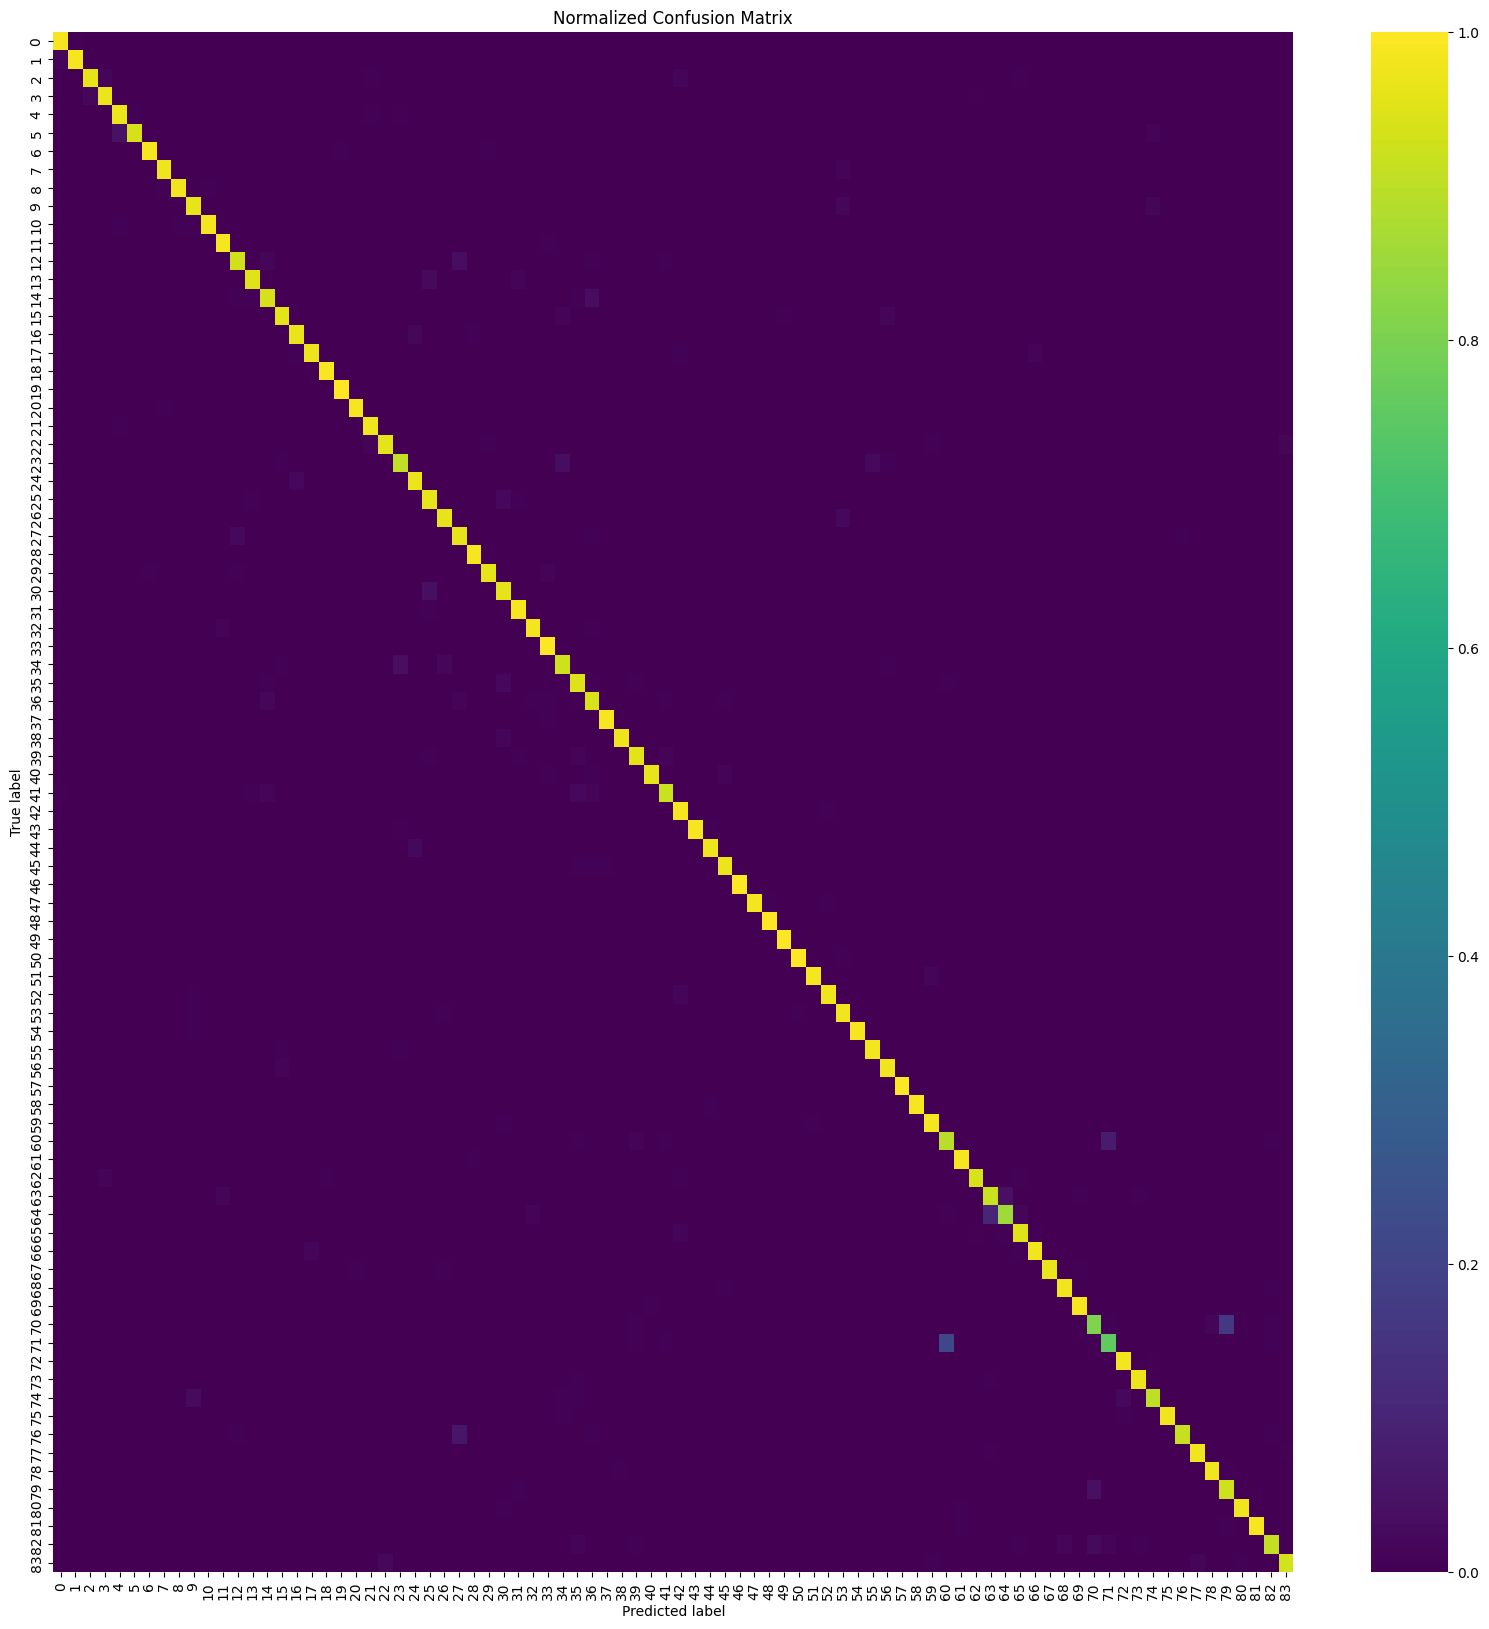

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# true and predicted labels
cm = confusion_matrix(y_true, y_pred, labels=range(84))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(cm_normalized, annot=False, cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


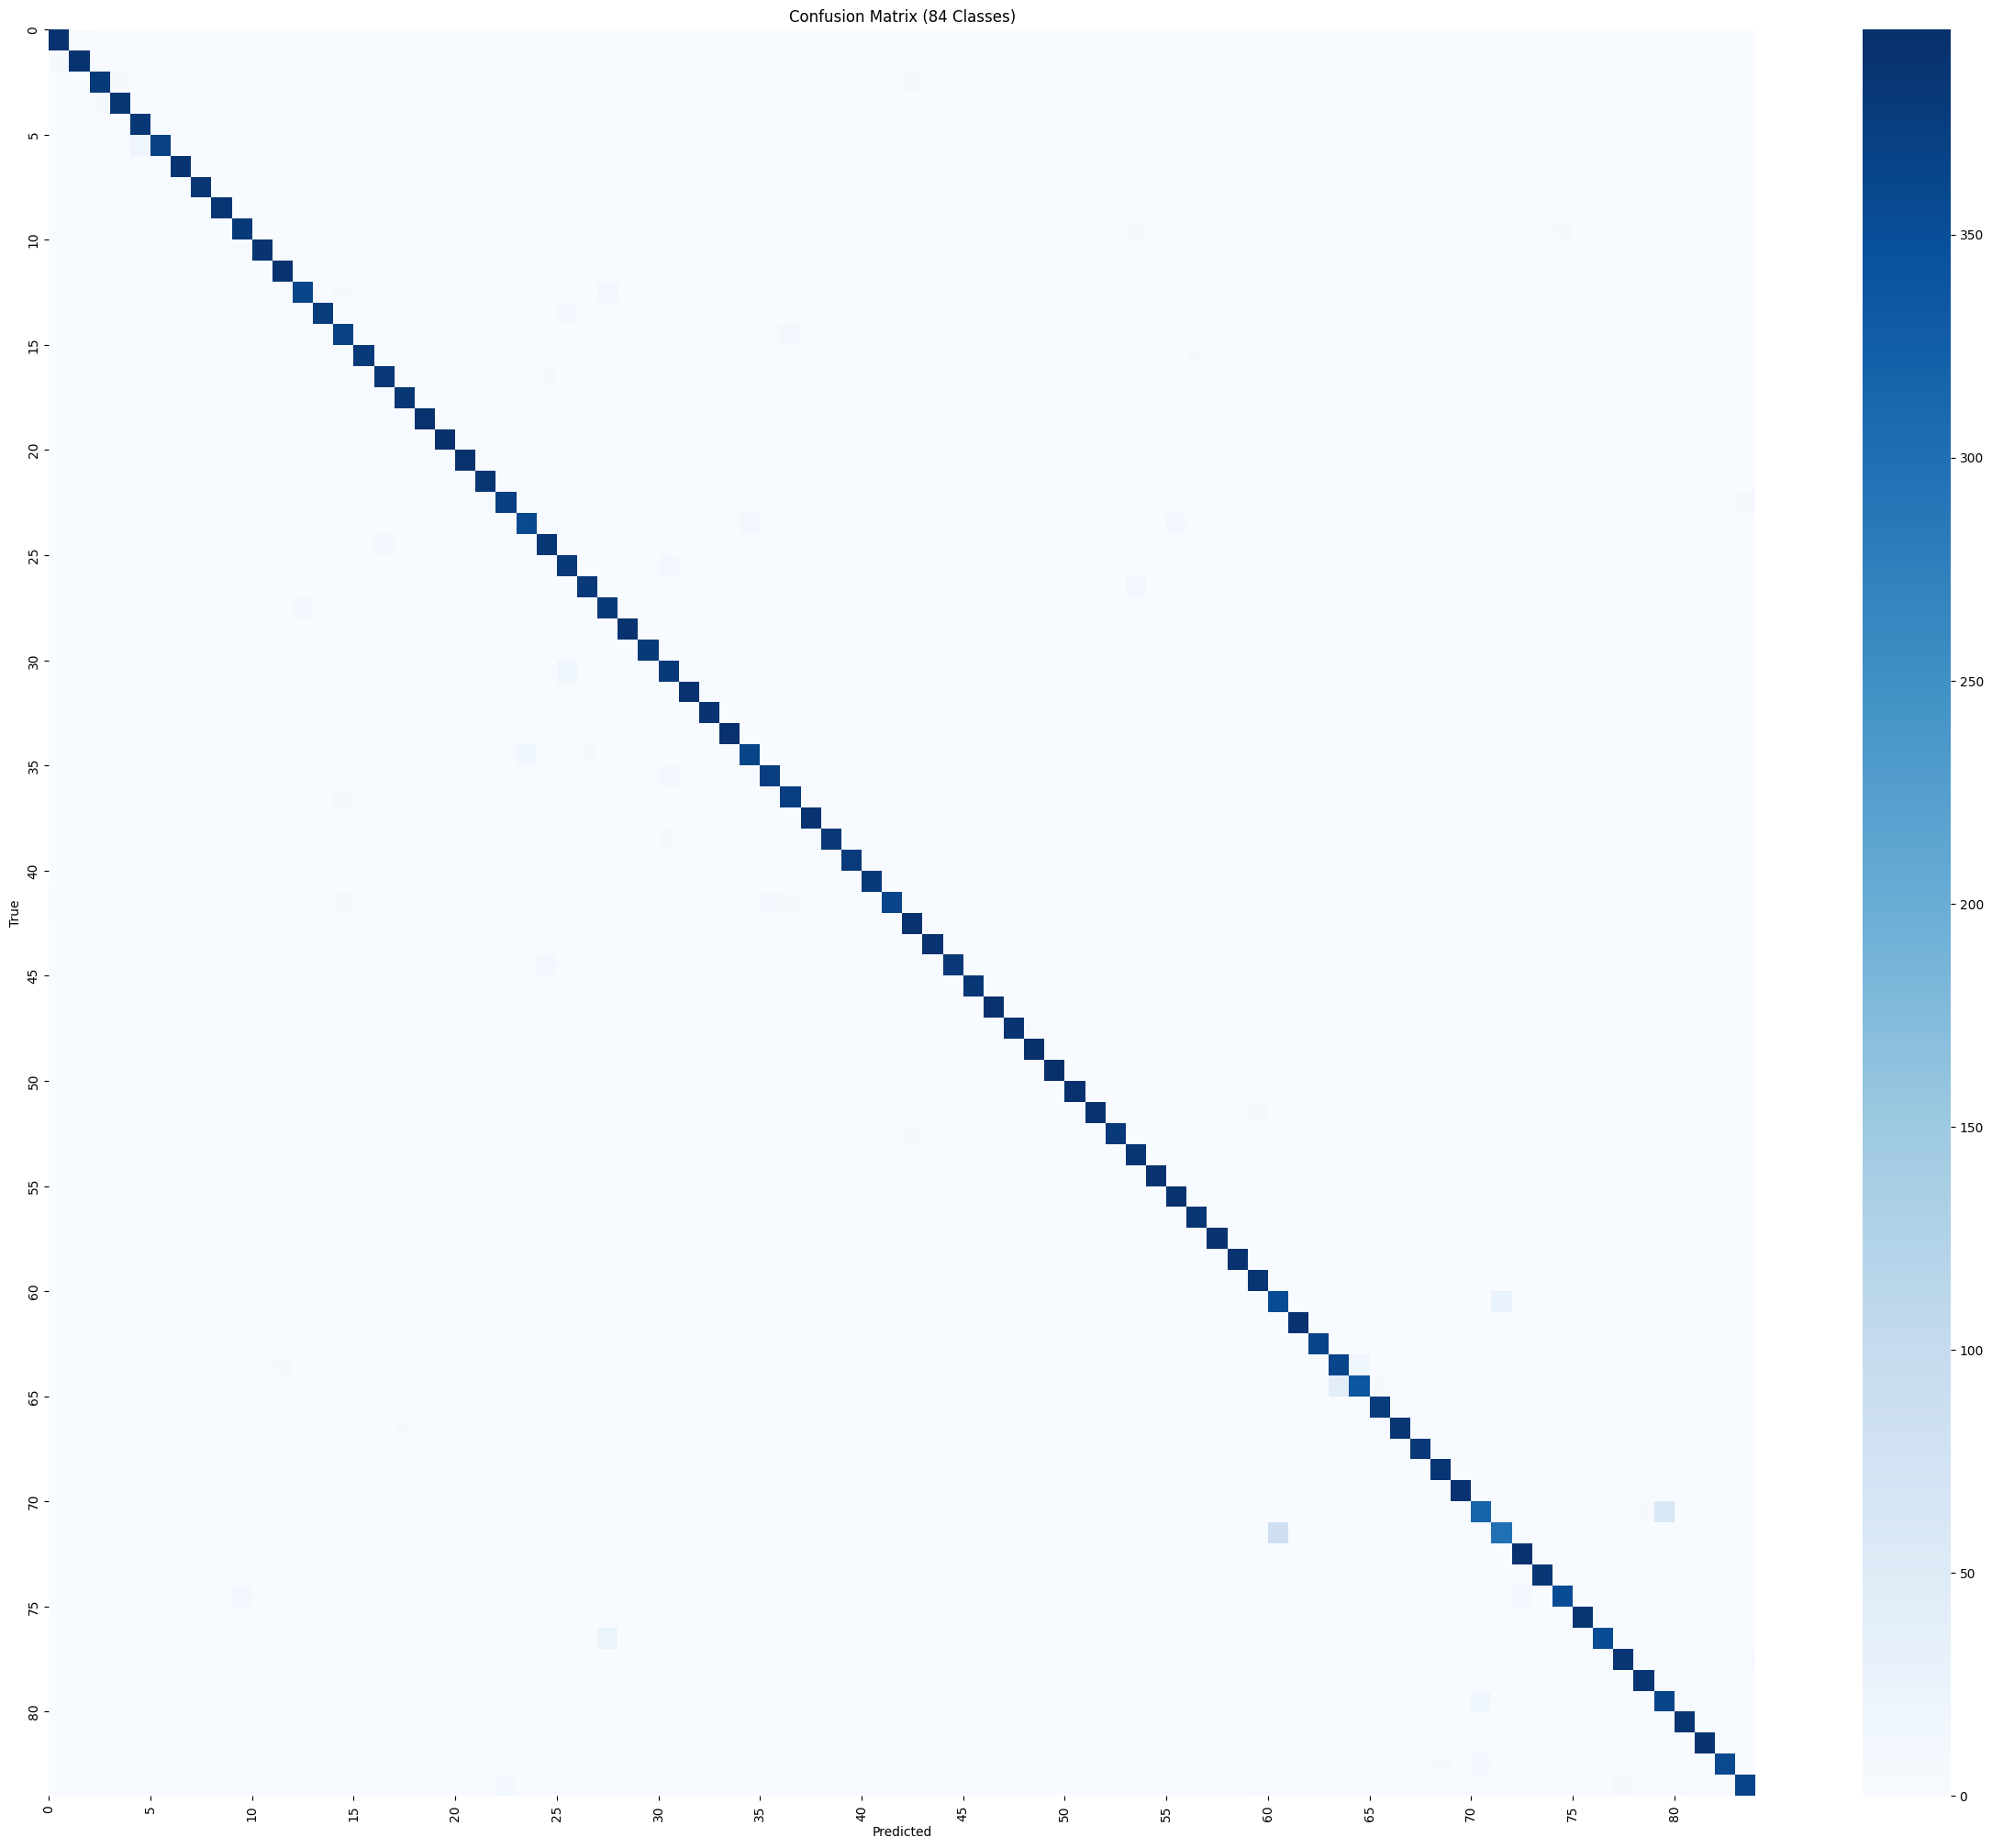

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30, 25))  # Bigger figure
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('Confusion Matrix (84 Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=range(0, 84, 5), labels=range(0, 84, 5), rotation=90)  # Sparse ticks
plt.yticks(ticks=range(0, 84, 5), labels=range(0, 84, 5))
plt.show()


In [12]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


519/519 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step
📋 Classification Report:

              precision    recall  f1-score   support

          01     0.9580    0.9823    0.9700       395
          02     0.9728    0.9924    0.9825       396
          03     0.9770    0.9696    0.9733       395
          04     0.9770    0.9672    0.9721       396
          05     0.9291    0.9596    0.9441       396
          06     0.9867    0.9369    0.9611       396
          07     0.9897    0.9772    0.9834       394
          08     0.9822    0.9748    0.9785       397
          09     0.9923    0.9773    0.9847       396
          10     0.9432    0.9646    0.9538       396
          11     0.9899    0.9874    0.9886       396
          12     0.9726    0.9874    0.9799       396
          13     0.9581    0.9313    0.9445       393
          14     0.9821    0.9672    0.9746       396
          15     0.9470    0.9494    0.9482       395
          16     0.9620    0.9596    0.9608       396
          17